In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
InputDir='/scratch/TESTS/Aim2/Inputs'
OutputDir='/scratch/TESTS/Aim2/Outputs'
MatlabFilesDir='/scratch/TESTS/Aim2/MatlabFiles'

label_fn = os.path.join(InputDir,'fswm_extended_neuro2012_20_merge_seg.nii.gz')
t1_fn = os.path.join(InputDir,'t1_average_BRAINSABC.nii.gz')
t2_fn = os.path.join(InputDir,'t2_average_BRAINSABC.nii.gz')
#dwi_fn = os.path.join(InputDir,'DWI_Corrected_Aligned_CS.nrrd')
dwi_fn = os.path.join(InputDir,'CorrectedDWI_in_T2Space.nrrd')

In [3]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from SEMTools import *

In [4]:
def ExtractBRAINFromHead(headImage, labelsMap):
    label_mask = labelsMap>0
    brainImage = sitk.Cast(headImage,sitk.sitkInt16) * sitk.Cast(label_mask,sitk.sitkInt16)
    return brainImage

In [5]:
labelMap = sitk.ReadImage(label_fn)

In [6]:
# Now we read dwi image and extract its b0
myExtracter = extractNrrdVectorIndex()
myExtracter.inputs.inputVolume = dwi_fn
myExtracter.inputs.vectorIndex = 1
myExtracter.inputs.outputVolume = os.path.join(OutputDir,'dwi_g1.nrrd')
print(myExtracter.cmdline)
myExtracter.run()

INFO:interface:stdout 2016-01-09T21:51:39.696697:Input Image: /scratch/TESTS/Aim2/Inputs/CorrectedDWI_in_T2Space.nrrd
INFO:interface:stdout 2016-01-09T21:51:39.696697:Output Image: /scratch/TESTS/Aim2/Outputs/dwi_g1.nrrd
INFO:interface:stdout 2016-01-09T21:51:39.696697:Vector Index: 1
INFO:interface:stdout 2016-01-09T21:51:39.696697:Set Image Orientation: AsAcquired
INFO:interface:stdout 2016-01-09T21:51:39.696697:


 extractNrrdVectorIndex  --inputVolume /scratch/TESTS/Aim2/Inputs/CorrectedDWI_in_T2Space.nrrd --outputVolume /scratch/TESTS/Aim2/Outputs/dwi_g1.nrrd --vectorIndex 1


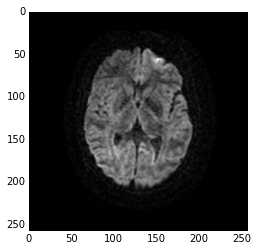

In [7]:
dwi_g1 = sitk.ReadImage(myExtracter.inputs.outputVolume)
myshow(dwi_g1)

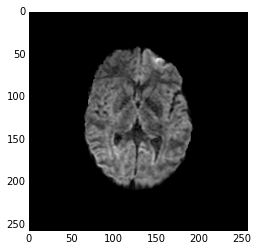

In [8]:
# Now resample the brain mask to normalized space to remove DWI skull
resampler2 = sitk.ResampleImageFilter()
resampler2.SetReferenceImage(dwi_g1)
resampler2.SetInterpolator(sitk.sitkNearestNeighbor)
labelMap = resampler2.Execute(labelMap)

dwi_g1 = ExtractBRAINFromHead(dwi_g1,labelMap)
myshow(dwi_g1)

In [9]:
print(dwi_g1.GetSize())
print(dwi_g1.GetDirection())
print(dwi_g1.GetOrigin())

(256, 256, 61)
(0.9918539561569646, 0.05181217926069737, 0.11636678106760484, -0.028214547076287348, 0.9802080203863694, -0.19594942230972467, -0.12421621870375261, 0.19106997370202405, 0.9736850600478829)
(-140.12465793097655, -86.4420614591275, -72.24374524354596)


In [10]:
# Now set direction cosign of all images to identity
def ForceDCtoID(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    return inputVolume

def ForceOriginToZero(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetOrigin((0.0, 0.0, 0.0))
    return inputVolume

In [11]:
dwi_g1 = ForceDCtoID(dwi_g1)
dwi_g1 = ForceOriginToZero(dwi_g1)

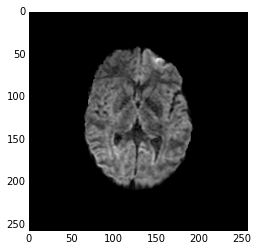

In [13]:
myshow(dwi_g1)

In [14]:
print(dwi_g1.GetSize())
print(dwi_g1.GetDirection())
print(dwi_g1.GetOrigin())

(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)


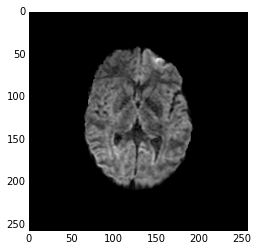

In [17]:
#
#
# Now we follow all processes in 2D space
# 's' means slice

dwig1_s = dwi_g1[:,:,dwi_g1.GetSize()[2]/2]

myshow(dwig1_s)

#
#

In [18]:
# Now we have following goals:
# 1) save the axial 2d dwi file (dwib0_s) as a matlab file in "MatlabFiles" directory.
# 2) Create edge mask from cobinations of t1d_s and t2d_s

In [19]:
def NormalizeBetweenZeroAndOne(image):
    image_double = sitk.Cast(image, sitk.sitkFloat32)
    # new range
    newMax=1.0
    newMin=0
    # Find old range
    totalStats = sitk.StatisticsImageFilter()
    totalStats.Execute(image_double)
    oldMax=totalStats.GetMaximum()
    oldMin=totalStats.GetMinimum()
    f=(newMax-newMin)/(oldMax-oldMin)
    Normalized_image = (image_double-oldMin)*f+newMin
    return Normalized_image

In [20]:
# GOAL 1

In [21]:
print(dwig1_s.GetSize())
print(dwig1_s.GetSpacing())

#print(dwib0_s.GetPixelIDTypeAsString())
# This step is important because "Undefined function 'fftn' for input arguments of type 'int16'"
#dwib0_s = sitk.Cast(dwib0_s, sitk.sitkUInt16)
#print(dwib0_s.GetPixelIDTypeAsString())


# Now normalize dwi_b0 to have values between 0 and 1
dwig1_s = NormalizeBetweenZeroAndOne(dwig1_s)
dwi_im_arr = sitk.GetArrayFromImage(dwig1_s)

import scipy.io
scipy.io.savemat(os.path.join(MatlabFilesDir,'dwig1_testdata.mat'), mdict={'inputImage': dwi_im_arr})

(256, 256)
(1.0, 1.0000000000000004)


In [ ]:
# GOAL 2